# STOP!!! READ THIS FIRST
You should only look at these solutions once you think you have working solutions of your own.
If you are working through Hogg 2010 then you are probably doing so **for your own benefit**. Thus, if you look at these early then you **aren't benefiting from the exercises at all**. Nobody is impressed at how correct your code is. The point is to learn by doing, not by copying.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True, fontsize=24) #If this gives a warning just ignore it
plt.rc("errorbar", capsize=3) #Ignore

/home/tom/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<Container object of 3 artists>

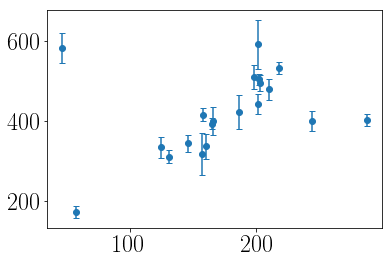

In [3]:
#Exercise 6
#Get the data. We only want x, y and the error on y
_, x_all, y_all, sigy_all, _, _ = np.genfromtxt("data.txt", unpack=True, delimiter='&', skip_header=1)
x    = x_all
y    = y_all
sigy = sigy_all
plt.errorbar(x, y, sigy, marker='o', ls='')

In [5]:
#Write our likelihood. First step is a prior
def lnprior(params):
    m, b = params
    Pb = Vb = Yb = 0
    #m, b, Pb, Yb, Vb = params
    if m < 0 or b < 0: return -np.inf
    if Pb < 0 or Pb > 1: return -np.inf
    if Vb < 0 or Vb > 10000: return -np.inf
    if Yb < 0 or Yb > 650: return -np.inf
    return 0

#Now a probability
def lnprob(params, x, y, sigy):
    m, b = params
    Pb = Vb = Yb =0
    #m, b, Pb, Yb, Vb = params
    sigy2 = sigy**2
    pi2 = 2*np.pi
    outside = -0.5*(y-m*x-b)**2/sigy2
    left  = (1.-Pb)/np.sqrt(pi2*sigy2)
    right = Pb/np.sqrt(pi2*(Vb+sigy2))*np.exp(-0.5*(y-Yb)**2/(Vb+sigy2)+0.5*(y-m*x-b)**2/sigy2)
    tot = left+right
    tot[tot==0] = 1.0
    result = np.log(tot) + outside
    for i in range(len(result)):
        print result[i], left[i], right[i], outside[i]
    return np.sum(result)

#Now the total likelihood
def lnlike(params, x, y ,sigy):
    lp = lnprior(params)
    if not np.isfinite(lp): return -np.inf
    return lp + lnprob(params, y, x, sigy)

guess = [2.2, 34.]#, 0.2, 10.0, 200.0]
print lnlike(guess, x, y, sigy)

-178.253832822 0.00654003738363 0.0 -173.224020425
-365.620086358 0.0159576912161 0.0 -361.482272
-562.688159042 0.0104984810632 0.0 -558.131634349
-889.55134429 0.0265961520268 0.0 -885.924355556
nan 0.0189972514477 nan -959.637188209
-286.212677623 0.0265961520268 0.0 -282.585688889
-532.700948239 0.0147756400149 0.0 -528.48617284
nan 0.0284958771715 nan -2257.92
-514.189024804 0.0132980760134 0.0 -509.868888889
nan 0.0249338925251 nan -1222.65125
nan 0.0284958771715 nan -1372.88
-523.073142358 0.0159576912161 0.0 -518.935328
-65.8789396482 0.0076719669308 0.0 -61.0087573964
-677.136527255 0.0249338925251 0.0 -673.445
-246.445299058 0.0117335964824 0.0 -242.0
-201.396193167 0.0128691058194 0.0 -197.04326743
-176.48709568 0.00949862572384 0.0 -171.830487528
-310.743928562 0.0153439338616 0.0 -306.566893491
nan 0.0249338925251 nan -1908.84757813
-433.521385945 0.0181337400182 0.0 -429.511404959
nan


/home/tom/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: overflow encountered in exp
/home/tom/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in multiply


True [  4.25571186  28.49839828]
   direc: array([[  0.00000000e+00,   1.00000000e+00],
       [ -1.62515934e-05,   4.34921689e-05]])
     fun: 280.34437175872529
 message: 'Optimization terminated successfully.'
    nfev: 136
     nit: 2
  status: 0
 success: True
       x: array([  4.25571186,  28.49839828])


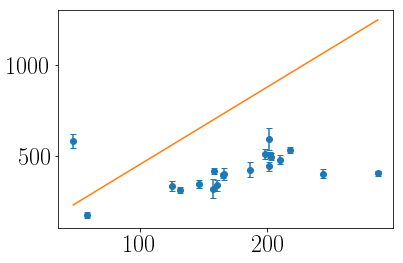

In [61]:
#Start by sampling with a maximum likelihood approach
from scipy import optimize as op
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, guess, args=(x, y, sigy), method='Powell')
print result['success'],result['x']
print result
plt.errorbar(x, y, sigy, marker='o', ls='')
m, b = result['x'][:2]
domain = np.linspace(min(x), max(x), 100)
plt.plot(domain, m*domain+b)

In [5]:
#Set up an MCMC using emcee
import emcee
ndim, nwalkers = 5, 20
pos = [result['x'] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(x, y, sigy))
output = sampler.run_mcmc(pos, 1000) #We don't use "output" at all

/home/tom/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/tom/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


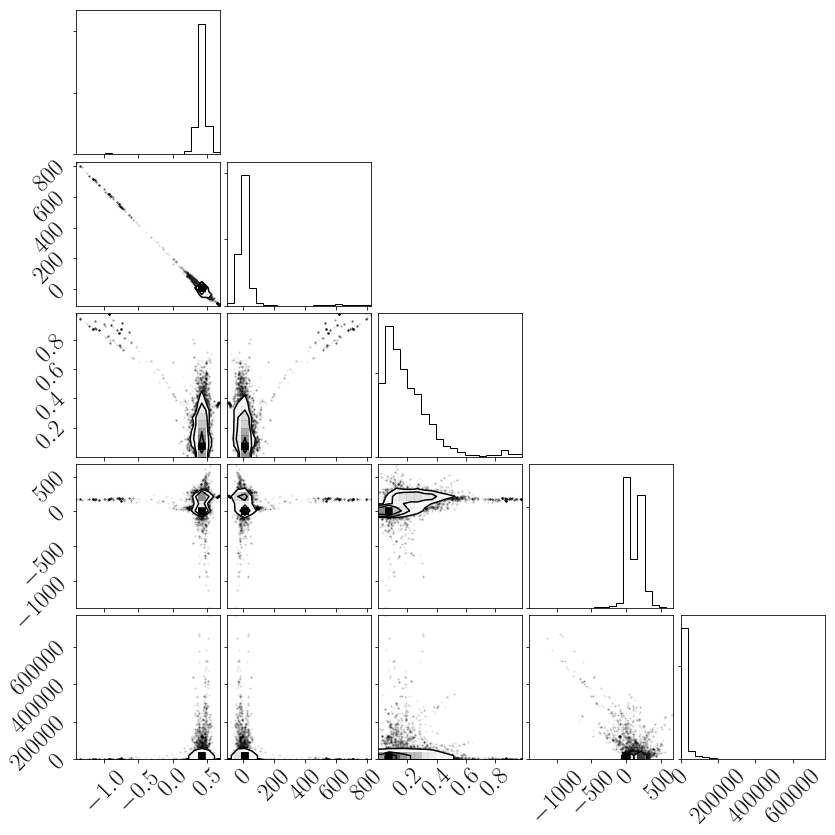

In [6]:
#See the results with a corner
import corner
nburn = 200
chain = sampler.flatchain[nburn*nwalkers:] #Chop off the "burn in"
fig = corner.corner(chain)